In [1]:
import numpy as np
from numpy import *
import pandas as pd
import h5py
import os
import re
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.signal as signal
import scipy.io as sio
import scipy.stats
from scipy.fft import fft
import neurokit2 as nk
import heartpy as hp
import nolds
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings
import nolds
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.read_csv("/Users/jinyanwei/Desktop/BP_Model/Jinyw_code/cc_mae/wave_ppg_ecg_1.csv")

,Unnamed: 0,refbp_estbp_cc,refbp_ppg_cc,refbp_ecg_cc,refbp_estbp_md,refbp_ppg_md,refbp_ecg_md,refbp_estbp_sd,refbp_ppg_sd,refbp_ecg_sd
0,0,0.990343,0.960967,0.160424,-1.751412,90.623408,90.742034,2.939531,19.494784,19.623261


In [2]:
import sys
sys.path.append('/Users/jinyanwei/Desktop/BP_Model/Jinyw_code/')
from read_data import open_data
from filter_and_clean_data import clean_data
from segment_and_features import features_data
from random_forest import run_random_forest

all_data = open_data('/Users/jinyanwei/Desktop/BP_Model/Data/UCI/Part_1.mat')

In [3]:
class SelectData:
    def __init__(self, data_array, data_begin=0, data_end=-1):
        self.array = data_array[data_begin:data_end]

    def signal_data(self): # PPG, BP, ECG
        return self.array[:,0], self.array[:,1], self.array[:,2]

    def show_data(self, show_begin=0, show_end=-1):
        fig, ax = plt.subplots(figsize=(30,6), dpi=300)
        ax.plot(self.array[show_begin:show_end])
        plt.show(fig)
        
def find_first_peak(signal):
    # Calculate the first order difference
    diff_signal = np.diff(signal)
    middle_signal = (np.max(signal) + np.min(signal))/2
    # Find the index of the first positive-to-negative transition
    for i in range(len(diff_signal) - 1):
        if (diff_signal[i] > 0 and diff_signal[i + 1] < 0) and (signal[i] > middle_signal):
            return i + 1
    return -1

def align_first_peaks(signal1, signal2):
    # Find the index of the first peak in each signal
    first_peak_index1 = find_first_peak(signal1)
    first_peak_index2 = find_first_peak(signal2)
    index_diff = first_peak_index1 - first_peak_index2
    if index_diff < 0:
        aligned_signal1 = signal1
        aligned_signal2 = signal2[abs(index_diff):]
    elif index_diff > 0:
        aligned_signal1 = signal1[index_diff:]
        aligned_signal2 = signal2
    else:
        aligned_signal1 = signal1
        aligned_signal2 = signal2

    return aligned_signal1, aligned_signal2

def cleaned_data(ppg_aligned, bp_aligned, ecg_standardized):
    sampling_rate = 125
    ecgpeaks, _ = signal.find_peaks(ecg_standardized, distance=sampling_rate//2.5)
    sum_beats = 0
    times_recorder = []
    cleaned_df = pd.DataFrame()
    for R_peak_number in range(len(ecgpeaks)-1):
        sum_beats += 1
        if ecg_standardized[ecgpeaks[R_peak_number]] > 0.2 and ecg_standardized[ecgpeaks[R_peak_number + 1]]>0.2:
            onebeat_bppeak, _ = signal.find_peaks(bp_aligned[ecgpeaks[R_peak_number]:ecgpeaks[R_peak_number + 1]], distance = sampling_rate//2.5)
            if len(onebeat_bppeak) == 1 : # make sure only one BP signal for one beat 
                saved_df = pd.DataFrame([ppg_aligned[ecgpeaks[R_peak_number]:ecgpeaks[R_peak_number + 1]], bp_aligned[ecgpeaks[R_peak_number]:ecgpeaks[R_peak_number + 1]], ecg_standardized[ecgpeaks[R_peak_number]:ecgpeaks[R_peak_number + 1]]]).T
                cleaned_df = pd.concat([cleaned_df, saved_df])
                times_recorder.append(sum_beats)
    cleaned_df.columns=('PPG', 'BP', 'ECG')
    return cleaned_df

from numpy.fft import fft

def extract_ppg_features(signal):

    '''
    #### Chaotic features

    lyap_r = nolds.lyap_r(signal)
    hurst_exp = nolds.hurst_rs(signal)
    corr_dim = nolds.corr_dim(signal, 1)

    '''

    #### Time domain features
    mean = np.mean(signal)
    std_dev = np.std(signal)
    skewness = scipy.stats.skew(signal)
    kurtosis = scipy.stats.kurtosis(signal)

    #### Frequency domain features
    fft_values = fft(signal)
    power_spectrum = np.abs(fft_values)**2
    total_power = np.sum(power_spectrum)
    low_freq_power = np.sum(power_spectrum[:len(power_spectrum)//2]) / total_power
    high_freq_power = np.sum(power_spectrum[len(power_spectrum)//2:]) / total_power

    ppg_features = {
        #'lyap_r': lyap_r,
        #'hurst_exp': hurst_exp,
        #'corr_dim': corr_dim,
        'ppg_mean': mean,
        'ppg_std_dev': std_dev,
        'ppg_skewness': skewness,
        'ppg_kurtosis': kurtosis,
        'ppg_low_freq_power': low_freq_power,
        'ppg_high_freq_power': high_freq_power
    }

    return ppg_features

def extract_ecg_features(signal):

    '''
    #### Chaotic features

    lyap_r = nolds.lyap_r(signal)
    hurst_exp = nolds.hurst_rs(signal)
    corr_dim = nolds.corr_dim(signal, 1)

    '''

    # Time domain features
    mean = np.mean(signal)
    std_dev = np.std(signal)
    skewness = scipy.stats.skew(signal)
    kurtosis = scipy.stats.kurtosis(signal)

    # Frequency domain features
    fft_values = fft(signal)
    power_spectrum = np.abs(fft_values)**2
    total_power = np.sum(power_spectrum)
    low_freq_power = np.sum(power_spectrum[:len(power_spectrum)//2]) / total_power
    high_freq_power = np.sum(power_spectrum[len(power_spectrum)//2:]) / total_power

    ecg_features = {
        #'lyap_r': lyap_r,
        #'hurst_exp': hurst_exp,
        #'corr_dim': corr_dim,
        'ecg_mean': mean,
        'ecg_std_dev': std_dev,
        'ecg_skewness': skewness,
        'ecg_kurtosis': kurtosis,
        'ecg_low_freq_power': low_freq_power,
        'ecg_high_freq_power': high_freq_power
    }

    return ecg_features

def get_bp_features(df):
    sampling_rate = 125
    ecgpeaks, _ = signal.find_peaks(df['ECG'], distance=sampling_rate//2.5)
    ppg_segments, ecg_segments, SBPlist, DBPlist, bplist = [], [], [], [], []
    for peak_number in range(1, len(ecgpeaks)-2):    # data will be more stable from the second R-peak
        ppg_segments.append(df['PPG'][ecgpeaks[peak_number]:ecgpeaks[peak_number + 1]].values)
        ecg_segments.append(df['ECG'][ecgpeaks[peak_number]:ecgpeaks[peak_number + 1]].values)
        bplist = df['BP'][ecgpeaks[peak_number]:ecgpeaks[peak_number+1]]
        SBPlist.append(max(bplist))
        DBPlist.append(min(bplist))

    ppg_feature_list = [extract_ppg_features(ppg_segment) for ppg_segment in ppg_segments]
    ecg_feature_list = [extract_ecg_features(ecg_segment) for ecg_segment in ecg_segments]
    features_df = pd.concat([pd.DataFrame(ppg_feature_list), pd.DataFrame(ecg_feature_list)], axis=1)

    return np.array(SBPlist), np.array(DBPlist), features_df


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)  

def bp_lstm_model(train_features_df, train_bp):
    time_steps = 10
    X_train, y_train_ori = create_sequences(train_features_df, pd.DataFrame(train_bp), time_steps)
    y_train = np.around(((y_train_ori - y_train_ori.min()) / (y_train_ori.max() - y_train_ori.min())), decimals=4)
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 12)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=200, verbose=1)
    return model

def get_bp_point(test_features_df, test_bp, model):
    time_steps = 10
    X_test, y_test = create_sequences(test_features_df, pd.DataFrame(test_bp), time_steps)
    y_pred = model.predict(X_test)
    y_pred_recover = (y_pred * (y_test.max() - y_test.min())) + y_test.min()
    return y_test, y_pred_recover

def bp_wave_lstm_modle(df_train):
    time_steps = 10
    X_train, y_train_ori = create_sequences(df_train[['PPG', 'ECG']], df_train['BP'], time_steps)
    y_train = np.around(((y_train_ori - y_train_ori.min()) / (y_train_ori.max() - y_train_ori.min())), decimals=4)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 2)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, verbose=1)
    return model

def get_bp_wave(df_test, model):
    time_steps = 10
    X_test, y_test = create_sequences(df_test[['PPG', 'ECG']], df_test['BP'], time_steps)
    y_pred = model.predict(X_test)
    y_pred_recover = (y_pred * (y_test.max() - y_test.min())) + y_test.min()
    return y_test, y_pred_recover

In [5]:
def get_patient_list(patient_num):
    pat = 0
    pat_list = []

    while len(pat_list) < (patient_num*1.5):
        datapat = all_data[pat]
        if len(datapat) > 45000:
            pat_list.append(pat)
        pat += 1
    print(pat_list)

    patient_list = []
    data_ready = pd.DataFrame()
    for i in pat_list:
        patient_array = SelectData(all_data[i])
        ppg, bp, ecg = patient_array.signal_data()
        ppg_filtered = nk.signal_filter(ppg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ppg_standardized = np.around(((ppg_filtered - ppg_filtered.min()) / (ppg_filtered.max() - ppg_filtered.min())), decimals=4)
        ecg_filtered = nk.signal_filter(ecg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ecg_standardized = np.around(((ecg_filtered - ecg_filtered.min()) / (ecg_filtered.max() - ecg_filtered.min())), decimals=4)
        ppg_aligned, bp_aligned = align_first_peaks(ppg_standardized, bp)
        cleaned_df = cleaned_data(ppg_aligned, bp_aligned, ecg_standardized)
        if len(cleaned_df) > 45000:
            patient_list.append(i)
            data_ready = pd.concat([data_ready, cleaned_df[:22500]])
    data_ready.to_csv(f'wave_train_data{patient_list[0]}_{patient_list[-1]}.csv')
    train_sbp, train_dbp, train_features_df = get_bp_features(data_ready)
    train_features_df.to_csv(f'fearutes_train_data{patient_list[0]}_{patient_list[-1]}.csv')
    print(len(patient_list))
    return patient_list

In [ ]:
def for_one_patient(patient_number):  
    patient_array = SelectData(all_data[patient_number])
    ppg, bp, ecg = patient_array.signal_data()
    ppg_filtered = nk.signal_filter(ppg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
    ppg_standardized = np.around(((ppg_filtered - ppg_filtered.min()) / (ppg_filtered.max() - ppg_filtered.min())), decimals=4)
    ecg_filtered = nk.signal_filter(ecg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
    ecg_standardized = np.around(((ecg_filtered - ecg_filtered.min()) / (ecg_filtered.max() - ecg_filtered.min())), decimals=4)
    ppg_aligned, bp_aligned = align_first_peaks(ppg_standardized, bp)
    cleaned_df = cleaned_data(ppg_aligned, bp_aligned, ecg_standardized)
    ori_cleaned_df = cleaned_data(ppg_standardized, bp, ecg_standardized)
    train_sbp, train_dbp, train_features_df = get_bp_features(cleaned_df[:22500])
    sbp_lstm_model = bp_lstm_model(train_features_df, train_sbp)
    dbp_lstm_model = bp_lstm_model(train_features_df, train_dbp)
    bp_wave_lstm_model = bp_wave_lstm_modle(cleaned_df[:22500])

    cc_wave_list = []
    mae_lstm_list = []
    sampling_rate = 125
    time_steps = 10
    test_sbp, test_dbp, test_features_df = get_bp_features(cleaned_df[22500:26500])
    ref_sbp_lstm, est_sbp_lstm = get_bp_point(test_features_df, test_sbp, sbp_lstm_model)
    ref_dbp_lstm, est_dbp_lstm = get_bp_point(test_features_df, test_dbp, dbp_lstm_model)
    ref_sbp_lstm = np.squeeze(ref_sbp_lstm)
    est_sbp_lstm = np.squeeze(est_sbp_lstm)
    ref_dbp_lstm = np.squeeze(ref_dbp_lstm)
    est_dbp_lstm = np.squeeze(est_dbp_lstm)
    SelectData(np.array([ref_sbp_lstm, est_sbp_lstm]).T).show_data()
    SelectData(np.array([ref_dbp_lstm, est_dbp_lstm]).T).show_data()
    ref_bp_wave, est_bp_wave = get_bp_wave(cleaned_df[22500:26500], bp_wave_lstm_model)
    est_bp_wave = np.squeeze(est_bp_wave)
    ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_wave, np.squeeze(est_bp_wave))
    ppg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:22500+time_steps+len(ref_bp_wave)]['PPG']))
    ori_ppg_wave = np.squeeze(np.array(ori_cleaned_df[22500+time_steps:(22500+time_steps+len(est_bp_wave))]['PPG']))
    min_len_est = min(len(ref_bp_aligned), len(est_bp_aligned))
    ref_bp_wave_a, ppg_wave_a = align_first_peaks(ref_bp_wave, ppg_wave)
    min_len_ppg = min(len(ref_bp_wave_a), len(ppg_wave_a))

    correlation_matrix_1 = np.corrcoef(ref_bp_wave, est_bp_wave)
    correlation_coefficient_1 = correlation_matrix_1[0, 1]
    correlation_matrix_2 = np.corrcoef(ref_bp_wave_a[:min_len_ppg], ppg_wave_a[:min_len_ppg])
    correlation_coefficient_2 = correlation_matrix_2[0, 1]
    correlation_matrix_3 = np.corrcoef(ref_bp_wave[:min_len_est], est_bp_aligned[:min_len_est])
    correlation_coefficient_3 = correlation_matrix_3[0, 1]
    correlation_matrix_4 = np.corrcoef(ref_bp_wave, ori_ppg_wave)
    correlation_coefficient_4 = correlation_matrix_4[0, 1]
    cc_wave_list += [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3, correlation_coefficient_4]

    mae_bp1 = np.mean(np.abs(ref_sbp_lstm - est_sbp_lstm))
    mae_bp2 = np.mean(np.abs(ref_dbp_lstm - est_dbp_lstm))
    mae_bp3 = np.mean(np.abs(ref_bp_wave - est_bp_wave))
    mae_lstm_list += [mae_bp1, mae_bp2, mae_bp3]

    SelectData(np.array([ref_sbp_lstm, est_sbp_lstm]).T).show_data()
    SelectData(np.array([ref_dbp_lstm, est_dbp_lstm]).T).show_data()
    SelectData(np.array([ref_bp_wave, est_bp_wave]).T).show_data()
    SelectData(np.array([ref_bp_wave, est_bp_aligned]).T).show_data()
    SelectData(ppg_wave).show_data()
    SelectData(ref_bp_wave).show_data()
    SelectData(ori_ppg_wave).show_data()
    SelectData(ppg_wave_a[:min_len_ppg]).show_data()
    SelectData(ref_bp_wave_a[:min_len_ppg]).show_data()
    print(cc_wave_list)
    print(mae_lstm_list)
    return

In [ ]:
## 3*（10， 30， 60）ppg 
def for_bp_ppg_cc_mae(patient_list):
    cc_wave_df10 = pd.DataFrame(columns=(('refbp_estbp1', 'refbp_ppg1', 'refbp_aligened_estbp1', 'refbp_orippg1','refbp_estbp2', 'refbp_ppg2', 'refbp_aligened_estbp2', 'refbp_orippg2', 'refbp_estbp3', 'refbp_ppg3', 'refbp_aligened_estbp3', 'refbp_orippg3')))
    mae_lstm_df10 = pd.DataFrame(columns=(('refsbp_estsbp1', 'refdbp_estdbp1', 'refbpwave_estbpwave1', 'refsbp_estsbp2', 'refdbp_estdbp2', 'refbpwave_estbpwave2', 'refsbp_estsbp3', 'refdbp_estdbp3', 'refbpwave_estbpwave3')))
    cc_wave_df30 = pd.DataFrame(columns=(('refbp_estbp1', 'refbp_ppg1', 'refbp_aligened_estbp1', 'refbp_orippg1','refbp_estbp2', 'refbp_ppg2', 'refbp_aligened_estbp2', 'refbp_orippg2', 'refbp_estbp3', 'refbp_ppg3', 'refbp_aligened_estbp3', 'refbp_orippg3')))
    mae_lstm_df30 = pd.DataFrame(columns=(('refsbp_estsbp1', 'refdbp_estdbp1', 'refbpwave_estbpwave1', 'refsbp_estsbp2', 'refdbp_estdbp2', 'refbpwave_estbpwave2', 'refsbp_estsbp3', 'refdbp_estdbp3', 'refbpwave_estbpwave3')))
    cc_wave_df60 = pd.DataFrame(columns=(('refbp_estbp1', 'refbp_ppg1', 'refbp_aligened_estbp1', 'refbp_orippg1','refbp_estbp2', 'refbp_ppg2', 'refbp_aligened_estbp2', 'refbp_orippg2', 'refbp_estbp3', 'refbp_ppg3', 'refbp_aligened_estbp3', 'refbp_orippg3')))
    mae_lstm_df60 = pd.DataFrame(columns=(('refsbp_estsbp1', 'refdbp_estdbp1', 'refbpwave_estbpwave1', 'refsbp_estsbp2', 'refdbp_estdbp2', 'refbpwave_estbpwave2', 'refsbp_estsbp3', 'refdbp_estdbp3', 'refbpwave_estbpwave3')))
    for patient in patient_list:
        patient_array = SelectData(all_data[patient])
        ppg, bp, ecg = patient_array.signal_data()
        ppg_filtered = nk.signal_filter(ppg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ppg_standardized = np.around(((ppg_filtered - ppg_filtered.min()) / (ppg_filtered.max() - ppg_filtered.min())), decimals=4)
        ecg_filtered = nk.signal_filter(ecg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ecg_standardized = np.around(((ecg_filtered - ecg_filtered.min()) / (ecg_filtered.max() - ecg_filtered.min())), decimals=4)
        ppg_aligned, bp_aligned = align_first_peaks(ppg_standardized, bp)
        cleaned_df = cleaned_data(ppg_aligned, bp_aligned, ecg_standardized)
        ori_cleaned_df = cleaned_data(ppg_standardized, bp, ecg_standardized)
        train_sbp, train_dbp, train_features_df = get_bp_features(cleaned_df[:22500])
        sbp_lstm_model = bp_lstm_model(train_features_df, train_sbp)
        dbp_lstm_model = bp_lstm_model(train_features_df, train_dbp)
        cc_wave_list10, mae_lstm_list10 = [], []
        cc_wave_list30, mae_lstm_list30 = [], []
        cc_wave_list60, mae_lstm_list60 = [], []
        bp_wave_lstm_model = bp_wave_lstm_modle(cleaned_df[:22500])
        sampling_rate = 125
        time_steps = 10

        for i in range(3):
            test_sbp, test_dbp, test_features_df = get_bp_features(cleaned_df[(22500+(60*sampling_rate)*i):(22500+(60*sampling_rate)*(i+1))])
            ref_sbp_lstm, est_sbp_lstm = get_bp_point(test_features_df, test_sbp, sbp_lstm_model)
            ref_dbp_lstm, est_dbp_lstm = get_bp_point(test_features_df, test_dbp, dbp_lstm_model)
            ref_sbp_lstm = np.squeeze(ref_sbp_lstm)
            est_sbp_lstm = np.squeeze(est_sbp_lstm)
            ref_dbp_lstm = np.squeeze(ref_dbp_lstm)
            est_dbp_lstm = np.squeeze(est_dbp_lstm)
            ref_bp_wave, est_bp_wave = get_bp_wave(cleaned_df[(22500+(60*sampling_rate)*i):(22500+(60*sampling_rate)*(i+1))], bp_wave_lstm_model)
            est_bp_wave = np.squeeze(est_bp_wave)
            ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_wave, np.squeeze(est_bp_wave))
            ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_aligned, np.squeeze(est_bp_aligned))
            min_len_est = min(len(ref_bp_aligned), len(est_bp_aligned))
            ref_bp_aligned = ref_bp_aligned[:min_len_est]
            est_bp_aligned = est_bp_aligned[:min_len_est]
            ppg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:22500+time_steps+len(ref_bp_wave)]['PPG']))
            ori_ppg_wave = np.squeeze(np.array(ori_cleaned_df[22500+time_steps:(22500+time_steps+len(ref_bp_wave))]['PPG']))
            ref_bp_wave_a, ppg_wave_a = align_first_peaks(ref_bp_wave, ppg_wave)
            ref_bp_wave_a = ref_bp_wave_a[:min_len_ppg]
            ppg_wave_a = ppg_wave_a[:min_len_ppg]
            min_len_ppg = min(len(ref_bp_wave_a), len(ppg_wave_a))

            once_time = 10
            ref_bp_wave10 = ref_bp_wave[:int((once_time/60)*len(ref_bp_wave))]
            est_bp_wave10 = est_bp_wave[:int((once_time/60)*len(est_bp_wave))]
            ref_bp_wave_a10 = ref_bp_wave_a[:int((once_time/60)*len(ref_bp_wave_a))]
            ppg_wave_a10 = ppg_wave_a[:int((once_time/60)*len(ppg_wave_a))]
            ref_bp_aligned10 = ref_bp_aligned[:int((once_time/60)*len(ref_bp_aligned))]
            est_bp_aligned10 = est_bp_aligned[:int((once_time/60)*len(est_bp_aligned))]
            ori_ppg_wave10 = ori_ppg_wave[:int((once_time/60*len(ori_ppg_wave)))]

            correlation_matrix_1 = np.corrcoef(ref_bp_wave10, est_bp_wave10)
            correlation_coefficient_1 = correlation_matrix_1[0, 1]
            correlation_matrix_2 = np.corrcoef(ref_bp_wave_a10, ppg_wave_a10)
            correlation_coefficient_2 = correlation_matrix_2[0, 1]
            correlation_matrix_3 = np.corrcoef(ref_bp_aligned10, est_bp_aligned10)
            correlation_coefficient_3 = correlation_matrix_3[0, 1]
            correlation_matrix_4 = np.corrcoef(ref_bp_wave10, ori_ppg_wave10)
            correlation_coefficient_4 = correlation_matrix_4[0, 1]           

            ref_sbp_lstm10 = ref_sbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_sbp_lstm10 = est_sbp_lstm[:int((once_time/60)*len(est_sbp_lstm))]
            ref_dbp_lstm10 = ref_dbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_dbp_lstm10 = est_dbp_lstm[:int((once_time/60)*len(est_dbp_lstm))]
            mae_bp1 = np.mean(np.abs(ref_sbp_lstm10 - est_sbp_lstm10))
            mae_bp2 = np.mean(np.abs(ref_dbp_lstm10 - est_dbp_lstm10))
            mae_bp3 = np.mean(np.abs(ref_bp_wave10 - est_bp_wave10))

            cc_wave_list10 += [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3, correlation_coefficient_4]
            mae_lstm_list10 += [mae_bp1, mae_bp2, mae_bp3] 

            once_time = 30
            ref_bp_wave30 = ref_bp_wave[:int((once_time/60)*len(ref_bp_wave))]
            est_bp_wave30 = est_bp_wave[:int((once_time/60)*len(est_bp_wave))]
            ref_bp_wave_a30 = ref_bp_wave_a[:int((once_time/60)*len(ref_bp_wave_a))]
            ppg_wave_a30 = ppg_wave_a[:int((once_time/60)*len(ppg_wave_a))]
            ref_bp_aligned30 = ref_bp_aligned[:int((once_time/60)*len(ref_bp_aligned))]
            est_bp_aligned30 = est_bp_aligned[:int((once_time/60)*len(est_bp_aligned))]
            ori_ppg_wave30 = ori_ppg_wave[:int((once_time/60*len(ori_ppg_wave)))]

            correlation_matrix_1 = np.corrcoef(ref_bp_wave30, est_bp_wave30)
            correlation_coefficient_1 = correlation_matrix_1[0, 1]
            correlation_matrix_2 = np.corrcoef(ref_bp_wave_a30, ppg_wave_a30)
            correlation_coefficient_2 = correlation_matrix_2[0, 1]
            correlation_matrix_3 = np.corrcoef(ref_bp_aligned30, est_bp_aligned30)
            correlation_coefficient_3 = correlation_matrix_3[0, 1]
            correlation_matrix_4 = np.corrcoef(ref_bp_wave30, ori_ppg_wave30)
            correlation_coefficient_4 = correlation_matrix_4[0, 1]           

            ref_sbp_lstm30 = ref_sbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_sbp_lstm30 = est_sbp_lstm[:int((once_time/60)*len(est_sbp_lstm))]
            ref_dbp_lstm30 = ref_dbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_dbp_lstm30 = est_dbp_lstm[:int((once_time/60)*len(est_dbp_lstm))]
            mae_bp1 = np.mean(np.abs(ref_sbp_lstm30 - est_sbp_lstm30))
            mae_bp2 = np.mean(np.abs(ref_dbp_lstm30 - est_dbp_lstm30))
            mae_bp3 = np.mean(np.abs(ref_bp_wave30 - est_bp_wave30))
            cc_wave_list30 += [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3, correlation_coefficient_4]
            mae_lstm_list30 += [mae_bp1, mae_bp2, mae_bp3] 

            once_time = 60
            ref_bp_wave60 = ref_bp_wave[:int((once_time/60)*len(ref_bp_wave))]
            est_bp_wave60 = est_bp_wave[:int((once_time/60)*len(est_bp_wave))]
            ref_bp_wave_a60 = ref_bp_wave_a[:int((once_time/60)*len(ref_bp_wave_a))]
            ppg_wave_a60 = ppg_wave_a[:int((once_time/60)*len(ppg_wave_a))]
            ref_bp_aligned60 = ref_bp_aligned[:int((once_time/60)*len(ref_bp_aligned))]
            est_bp_aligned60 = est_bp_aligned[:int((once_time/60)*len(est_bp_aligned))]
            ori_ppg_wave60 = ori_ppg_wave[:int((once_time/60*len(ori_ppg_wave)))]

            correlation_matrix_1 = np.corrcoef(ref_bp_wave60, est_bp_wave60)
            correlation_coefficient_1 = correlation_matrix_1[0, 1]
            correlation_matrix_2 = np.corrcoef(ref_bp_wave_a60, ppg_wave_a60)
            correlation_coefficient_2 = correlation_matrix_2[0, 1]
            correlation_matrix_3 = np.corrcoef(ref_bp_aligned60, est_bp_aligned60)
            correlation_coefficient_3 = correlation_matrix_3[0, 1]
            correlation_matrix_4 = np.corrcoef(ref_bp_wave60, ori_ppg_wave60)
            correlation_coefficient_4 = correlation_matrix_4[0, 1]           

            ref_sbp_lstm60 = ref_sbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_sbp_lstm60 = est_sbp_lstm[:int((once_time/60)*len(est_sbp_lstm))]
            ref_dbp_lstm60 = ref_dbp_lstm[:int((once_time/60)*len(ref_sbp_lstm))]
            est_dbp_lstm60 = est_dbp_lstm[:int((once_time/60)*len(est_dbp_lstm))]
            mae_bp1 = np.mean(np.abs(ref_sbp_lstm60 - est_sbp_lstm60))
            mae_bp2 = np.mean(np.abs(ref_dbp_lstm60 - est_dbp_lstm60))
            mae_bp3 = np.mean(np.abs(ref_bp_wave60 - est_bp_wave60))
            cc_wave_list60 += [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3, correlation_coefficient_4]
            mae_lstm_list60 += [mae_bp1, mae_bp2, mae_bp3] 

        cc_wave_df10.loc[len(cc_wave_df10)] = cc_wave_list10
        mae_lstm_df10.loc[len(mae_lstm_df10)] =mae_lstm_list10
        cc_wave_df30.loc[len(cc_wave_df30)] = cc_wave_list30
        mae_lstm_df30.loc[len(mae_lstm_df30)] =mae_lstm_list30
        cc_wave_df60.loc[len(cc_wave_df60)] = cc_wave_list60
        mae_lstm_df60.loc[len(mae_lstm_df60)] =mae_lstm_list60
        display(cc_wave_df10)
        display(mae_lstm_df10)
        display(cc_wave_df30)
        display(mae_lstm_df30)
        display(cc_wave_df60)
        display(mae_lstm_df60)
        SelectData(np.array([ref_sbp_lstm, est_sbp_lstm]).T).show_data()
        SelectData(np.array([ref_dbp_lstm, est_dbp_lstm]).T).show_data()
        SelectData(np.array([ref_bp_wave, est_bp_wave]).T).show_data()
        SelectData(np.array([ref_bp_aligned, est_bp_aligned]).T).show_data()
        SelectData(ppg_wave_a[:min_len_ppg]).show_data()
        SelectData(ref_bp_wave_a[:min_len_ppg]).show_data()
    cc_wave_df10.to_csv(f'cc_wave10_{len(patient_list)}.csv')
    mae_lstm_df10.to_csv(f'mae_bp10_{len(patient_list)}.csv')
    cc_wave_df30.to_csv(f'cc_wave30_{len(patient_list)}.csv')
    mae_lstm_df30.to_csv(f'mae_bp30_{len(patient_list)}.csv')
    cc_wave_df60.to_csv(f'cc_wave60_{len(patient_list)}.csv')
    mae_lstm_df60.to_csv(f'mae_bp60_{len(patient_list)}.csv')
    return 

In [ ]:
patient_list = get_patient_list(120)


In [8]:
## 1* 30 (wave, ppg, ecg) cc
## 10min/patient
def cc_waveppgecg(patient_list):
    wave_ppg_ecg_df = pd.DataFrame(columns=(('refbp_estbp_cc', 'refbp_ppg_cc', 'refbp_ecg_cc', 'refbp_estbp_md', 'refbp_ppg_md', 'refbp_ecg_md', 'refbp_estbp_sd', 'refbp_ppg_sd', 'refbp_ecg_sd')))
    for patient in patient_list:
        patient_array = SelectData(all_data[patient])
        ppg, bp, ecg = patient_array.signal_data()
        ppg_filtered = nk.signal_filter(ppg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ppg_standardized = np.around(((ppg_filtered - ppg_filtered.min()) / (ppg_filtered.max() - ppg_filtered.min())), decimals=4)
        ecg_filtered = nk.signal_filter(ecg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
        ecg_standardized = np.around(((ecg_filtered - ecg_filtered.min()) / (ecg_filtered.max() - ecg_filtered.min())), decimals=4)
        ppg_aligned, bp_aligned = align_first_peaks(ppg_standardized, bp)
        cleaned_df = cleaned_data(ppg_aligned, bp_aligned, ecg_standardized)
        bp_wave_lstm_model = bp_wave_lstm_modle(cleaned_df[:22500])
        sampling_rate = 125
        once_time = 30
        time_steps = 10
        ref_bp_wave, est_bp_wave = get_bp_wave(cleaned_df[22500:(22500+30*sampling_rate)], bp_wave_lstm_model)
        est_bp_wave = np.squeeze(est_bp_wave)
        ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_wave, np.squeeze(est_bp_wave))
        ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_aligned, np.squeeze(est_bp_aligned))
        min_len_est = min(len(ref_bp_aligned), len(est_bp_aligned))
        ref_bp_aligned = ref_bp_aligned[:min_len_est]
        est_bp_aligned = est_bp_aligned[:min_len_est]
        ppg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:(22500+time_steps+len(ref_bp_wave))]['PPG']))
        ref_bp_wave_a, ppg_wave_a = align_first_peaks(ref_bp_wave, ppg_wave)
        min_len_ppg = min(len(ref_bp_wave_a), len(ppg_wave_a))
        ref_bp_wave_a = ref_bp_wave_a[:min_len_ppg]
        ppg_wave_a = ppg_wave_a[:min_len_ppg]
        ecg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:(22500+time_steps+len(ref_bp_wave))]['ECG']))

        correlation_matrix_1 = np.corrcoef(ref_bp_wave, est_bp_wave)
        correlation_coefficient_1 = correlation_matrix_1[0, 1]
        correlation_matrix_2 = np.corrcoef(ref_bp_wave_a, ppg_wave_a)
        correlation_coefficient_2 = correlation_matrix_2[0, 1]
        correlation_matrix_3 = np.corrcoef(ref_bp_wave, ecg_wave)
        correlation_coefficient_3 = correlation_matrix_3[0, 1]     
        cc_list = [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3]
        md1 = np.mean(ref_bp_wave - est_bp_wave)
        md2 = np.mean(ref_bp_wave_a - ppg_wave_a)
        md3 = np.mean(ref_bp_wave - ecg_wave)
        md_list = [md1, md2, md3]
        sd1 = np.std(ref_bp_wave - est_bp_wave)
        sd2 = np.std(ref_bp_wave_a - ppg_wave_a)
        sd3 = np.std(ref_bp_wave - ecg_wave)
        sd_list = [sd1, sd2, sd3]
        wave_ppg_ecg_list = cc_list + md_list + sd_list
        wave_ppg_ecg_df.loc[len(wave_ppg_ecg_df)] = wave_ppg_ecg_list

        display(wave_ppg_ecg_df)
        SelectData(np.array([ref_bp_wave, est_bp_wave]).T).show_data()
        SelectData(ref_bp_wave[1200:1800]).show_data()
        SelectData(est_bp_wave[1200:1800]).show_data()
        SelectData(ppg_wave_a[1200:1800]).show_data()
        SelectData(ecg_wave[1200:1800]).show_data()

    wave_ppg_ecg_df.to_csv(f'wave_ppg_ecg_{len(patient_list)}.csv')
    return

In [13]:
patient_array = SelectData(all_data[1])
ppg, bp, ecg = patient_array.signal_data()
ppg_filtered = nk.signal_filter(ppg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
ppg_standardized = np.around(((ppg_filtered - ppg_filtered.min()) / (ppg_filtered.max() - ppg_filtered.min())), decimals=4)
ecg_filtered = nk.signal_filter(ecg, lowcut=0.5, highcut=50, method='butterworth', order=2, sampling_rate=125)
ecg_standardized = np.around(((ecg_filtered - ecg_filtered.min()) / (ecg_filtered.max() - ecg_filtered.min())), decimals=4)
ppg_aligned, bp_aligned = align_first_peaks(ppg_standardized, bp)
cleaned_df = cleaned_data(ppg_aligned, bp_aligned, ecg_standardized)
bp_wave_lstm_model = bp_wave_lstm_modle(cleaned_df[:22500])
sampling_rate = 125
once_time = 30
time_steps = 10
ref_bp_wave, est_bp_wave = get_bp_wave(cleaned_df[22500:(22500+30*sampling_rate)], bp_wave_lstm_model)
est_bp_wave = np.squeeze(est_bp_wave)
ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_wave, np.squeeze(est_bp_wave))
ref_bp_aligned, est_bp_aligned = align_first_peaks(ref_bp_aligned, np.squeeze(est_bp_aligned))
min_len_est = min(len(ref_bp_aligned), len(est_bp_aligned))
ref_bp_aligned = ref_bp_aligned[:min_len_est]
est_bp_aligned = est_bp_aligned[:min_len_est]
ppg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:(22500+time_steps+len(ref_bp_wave))]['PPG']))
ref_bp_wave_a, ppg_wave_a = align_first_peaks(ref_bp_wave, ppg_wave)
min_len_ppg = min(len(ref_bp_wave_a), len(ppg_wave_a))
ref_bp_wave_a = ref_bp_wave_a[:min_len_ppg]
ppg_wave_a = ppg_wave_a[:min_len_ppg]
ecg_wave = np.squeeze(np.array(cleaned_df[22500+time_steps:(22500+time_steps+len(ref_bp_wave))]['ECG']))

correlation_matrix_1 = np.corrcoef(ref_bp_wave, est_bp_wave)
correlation_coefficient_1 = correlation_matrix_1[0, 1]
correlation_matrix_2 = np.corrcoef(ref_bp_wave_a, ppg_wave_a)
correlation_coefficient_2 = correlation_matrix_2[0, 1]
correlation_matrix_3 = np.corrcoef(ref_bp_wave, ecg_wave)
correlation_coefficient_3 = correlation_matrix_3[0, 1]     
cc_list = [correlation_coefficient_1, correlation_coefficient_2, correlation_coefficient_3]
md1 = np.mean(ref_bp_wave - est_bp_wave)
md2 = np.mean(ref_bp_wave_a - ppg_wave_a)
md3 = np.mean(ref_bp_wave - ecg_wave)
md_list = [md1, md2, md3]
sd1 = np.std(ref_bp_wave - est_bp_wave)
sd2 = np.std(ref_bp_wave_a - ppg_wave_a)
sd3 = np.std(ref_bp_wave - ecg_wave)
sd_list = [sd1, sd2, sd3]
wave_ppg_ecg_list = cc_list + md_list + sd_list



Epoch 1/100
703/703 [==============================] - 8s 7ms/step - loss: 0.0108
Epoch 2/100
703/703 [==============================] - 6s 8ms/step - loss: 0.0067
Epoch 3/100
703/703 [==============================] - 6s 8ms/step - loss: 0.0058
Epoch 4/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0050
Epoch 5/100
703/703 [==============================] - 5s 8ms/step - loss: 0.0046
Epoch 6/100
703/703 [==============================] - 6s 8ms/step - loss: 0.0043
Epoch 7/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0040
Epoch 8/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0038
Epoch 9/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0037
Epoch 10/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0035
Epoch 11/100
703/703 [==============================] - 5s 7ms/step - loss: 0.0033
Epoch 12/100
703/703 [==============================] - 6s 9ms/step - loss: 0.0031
Epoch 13/100


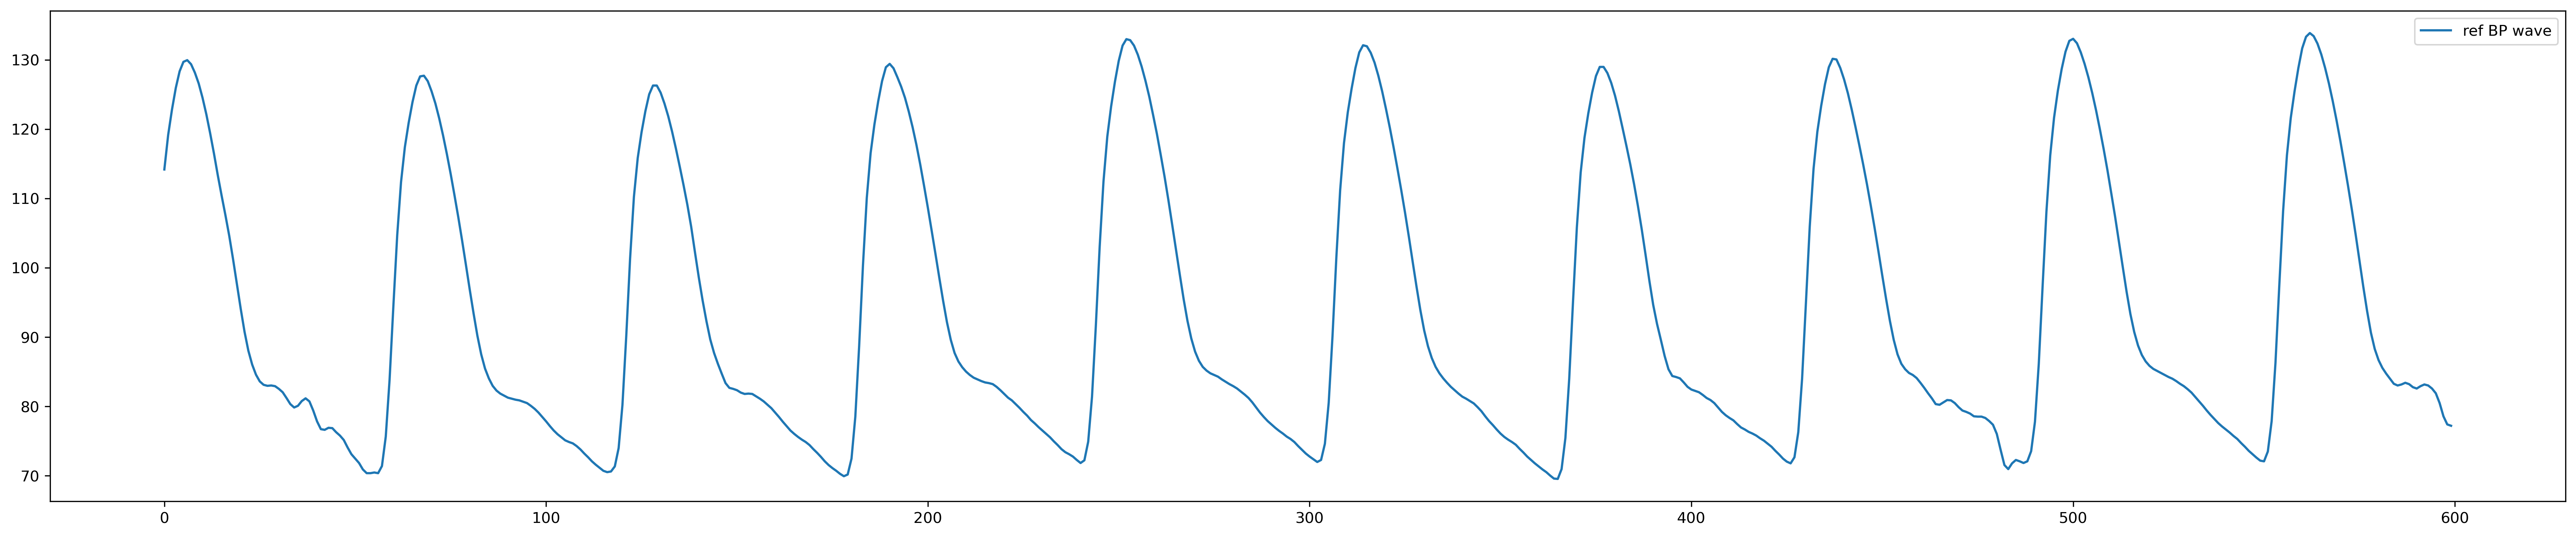

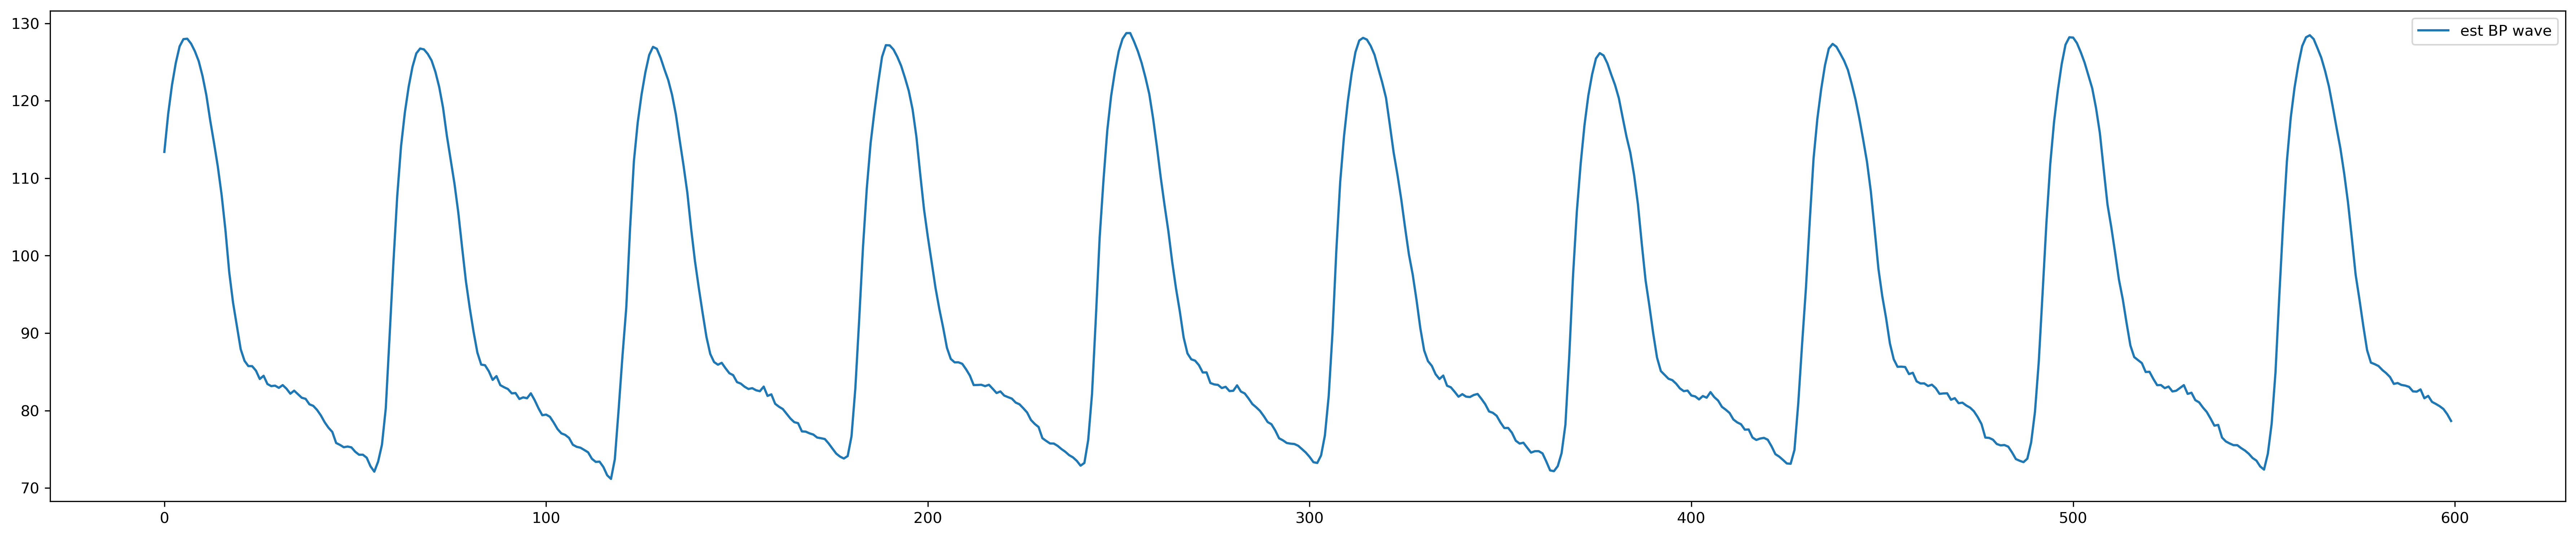

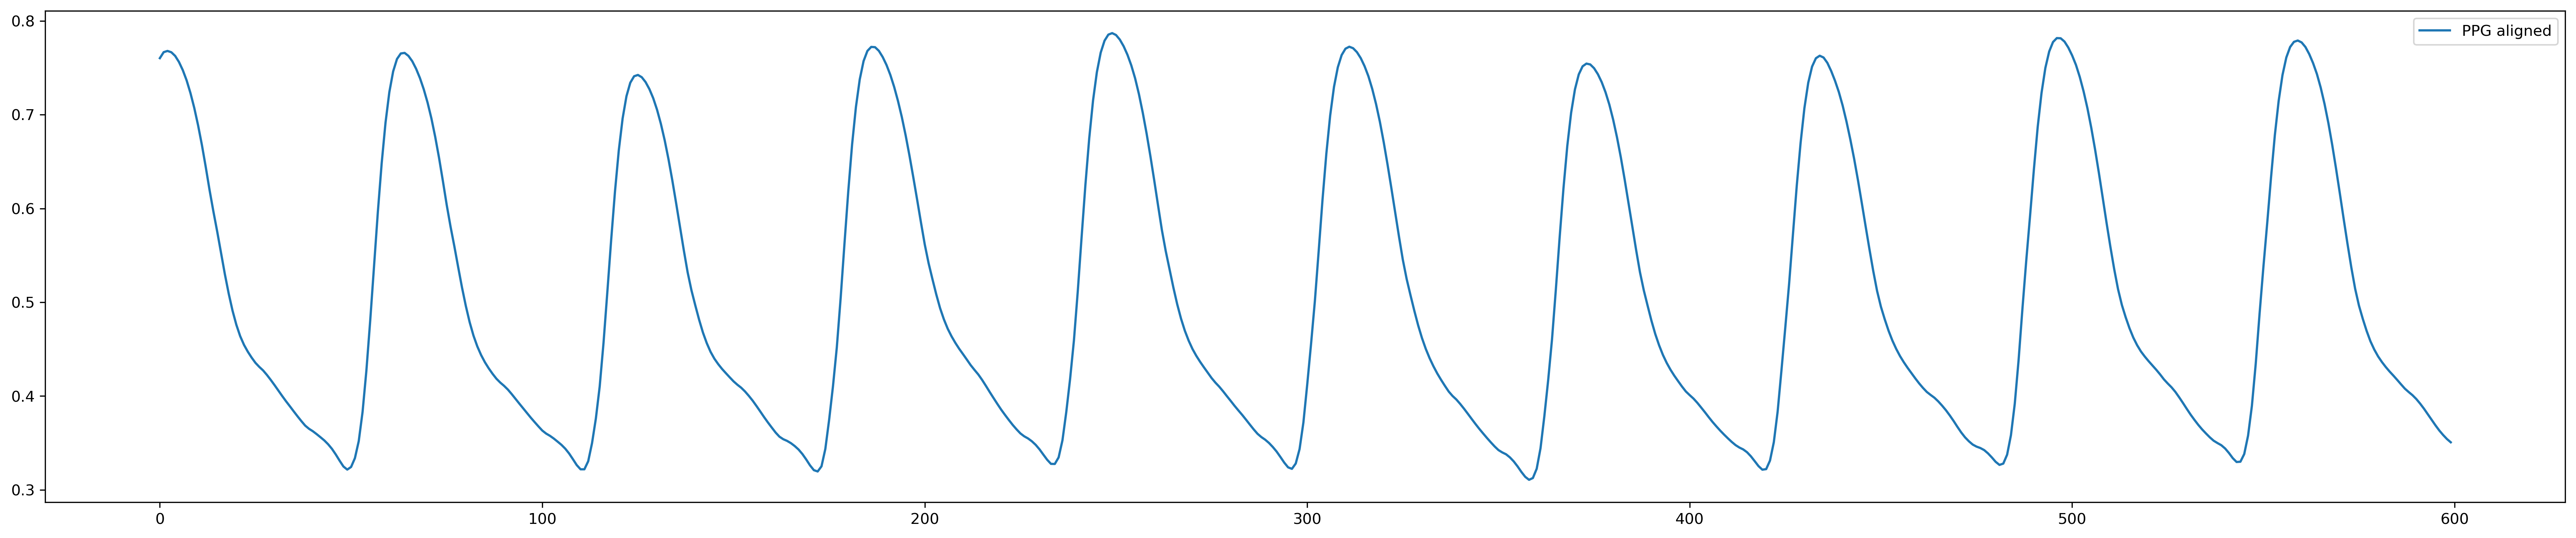

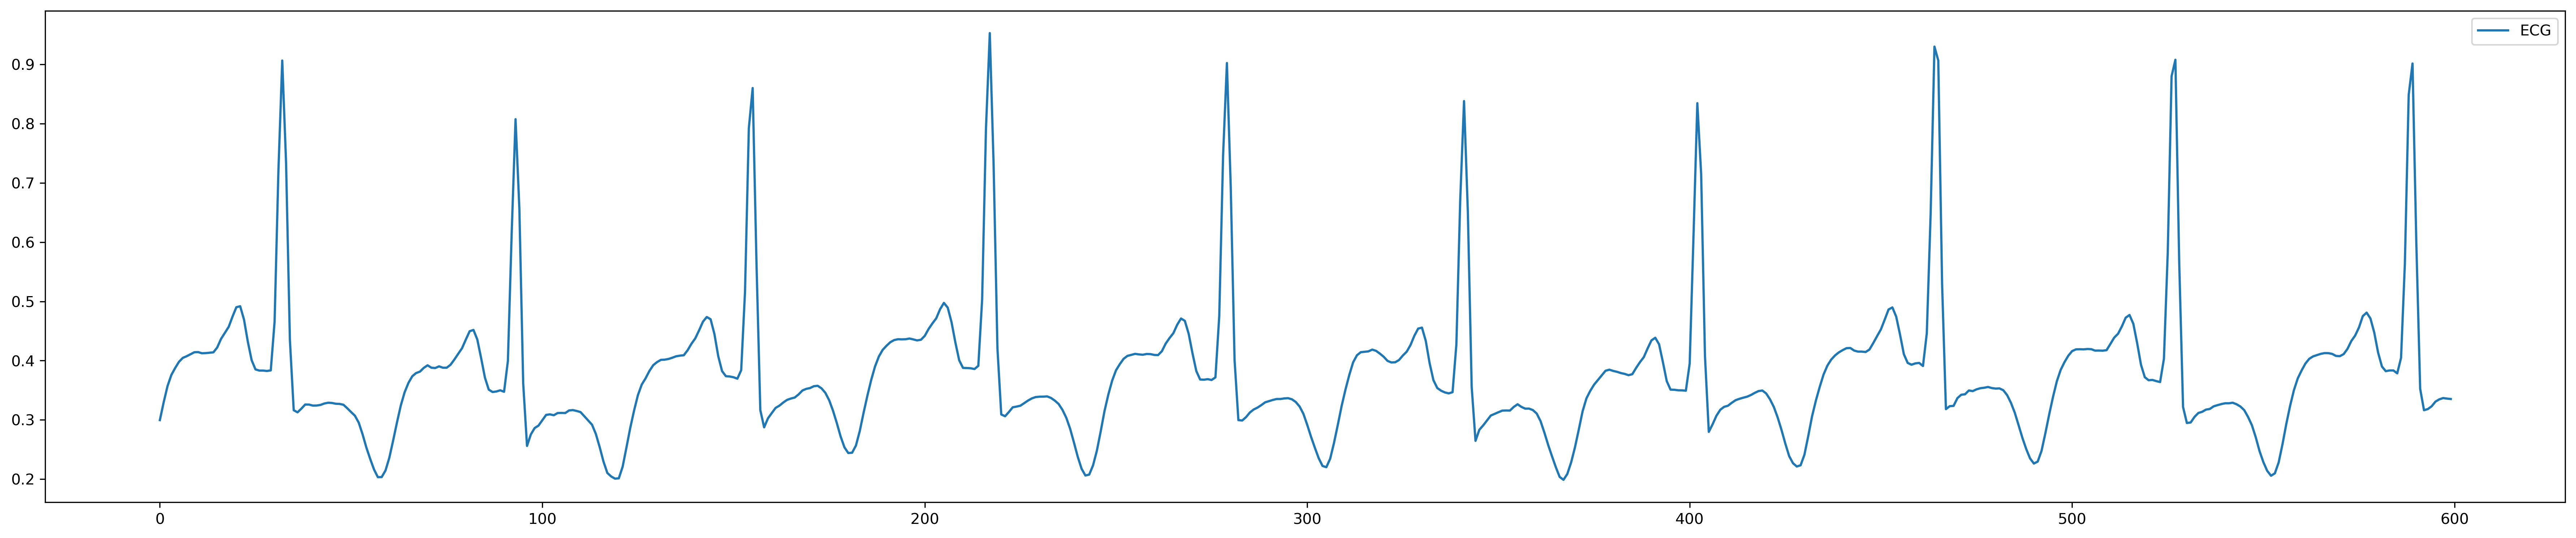

In [15]:
fig = plt.figure(figsize=(30,6), dpi=300)
plt.plot(ref_bp_wave[1200:1800], label='ref BP wave')
plt.legend()
plt.show()
fig = plt.figure(figsize=(30,6), dpi=300)
plt.plot(est_bp_wave[1200:1800], label='est BP wave')
plt.legend()
plt.show()
fig = plt.figure(figsize=(30,6), dpi=300)
plt.plot(ppg_wave_a[1200:1800], label='PPG aligned')
plt.legend()
plt.show()
fig = plt.figure(figsize=(30,6), dpi=300)
plt.plot(ecg_wave[1200:1800], label='ECG')
plt.legend()
plt.show()

In [ ]:
wave_ppg_ecg_df80 = pd.concat([pd.read_csv('wave_ppg_ecg10.csv'), pd.read_csv('wave_ppg_ecg_70.csv')])
# wave_ppg_ecg_df = wave_ppg_ecg_df.reset_index(drop=True)

In [ ]:
wave_ppg_ecg_df80.to_csv('wave_ppg_ecg80.csv')

In [ ]:
def cc_histogram(wave_ppg_ecg_df):
    plt.figure(figsize=(15, 6), dpi=300)
    # Set your color palette
    colors = ['#B0C4DE', '#5F9EA0', '#C6868E']

    # Specify data
    data1 = np.array(wave_ppg_ecg_df['refbp_estbp_cc'])
    data2 = np.array(wave_ppg_ecg_df['refbp_ppg_cc'])
    data3 = np.array(wave_ppg_ecg_df['refbp_ecg_cc'])

    # Create bins and histogram
    bins = np.linspace(0, 1, 11)
    counts1, _ = np.histogram(abs(data1), bins=bins)
    counts2, _ = np.histogram(abs(data2), bins=bins)
    counts3, _ = np.histogram(abs(data3), bins=bins)

    # Calculate frequencies
    freq1 = counts1 / len(data1)
    freq2 = counts2 / len(data2)
    freq3 = counts3 / len(data3)

    barWidth = 0.25
    r1 = np.arange(len(freq1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.bar(r1, freq1, color=colors[0], width=barWidth, edgecolor='grey', label='refBP_estBP')
    plt.bar(r2, freq2, color=colors[1], width=barWidth, edgecolor='grey', label='refBP_PPG')
    plt.bar(r3, freq3, color=colors[2], width=barWidth, edgecolor='grey', label='refBP_ECG')

    # Adding labels
    for i in range(len(r1)):
        plt.text(x = r1[i] + barWidth/2 - 0.1 , y = freq1[i] + 0.02, s = f"{counts1[i]}", size = 10, ha='center')
        plt.text(x = r2[i] + barWidth/2 - 0.1 , y = freq2[i] + 0.02, s = f"{counts2[i]}", size = 10, ha='center')
        plt.text(x = r3[i] + barWidth/2 - 0.1 , y = freq3[i] + 0.02, s = f"{counts3[i]}", size = 10, ha='center')

    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.xticks([r + barWidth for r in range(len(freq1))], ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0'])
    plt.legend()
    plt.show()
    return